In [17]:
import os
import librosa
import pandas as pd
import numpy as np
import soundfile as sf
from tqdm import tqdm
import random
import librosa
import multiprocessing as mp
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import multiprocessing as mp
import tarfile
import torch

In [6]:
# Путь к архиву 
archive_path = "speech_commands_v0.02.tar.gz"

# Куда распаковать
extract_path = "./data"

# Создаем папку, если её нет
os.makedirs(extract_path, exist_ok=True)

# Распаковываем
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(extract_path)

print(f"Архив распакован в: {extract_path}")

C:\Users\user1\AppData\Local\Temp\ipykernel_17552\1755908564.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_path)

KeyboardInterrupt



In [13]:
dataset_path = "./data"
print("Папки в датасете:", os.listdir(dataset_path)) 

Папки в датасете: ['eight', 'README.md', 'sheila', '_background_noise_', 'nine', 'yes', 'one', 'no', 'left', 'tree', 'bed', 'bird', 'go', 'wow', 'seven', 'marvin', 'dog', 'three', 'validation_list.txt', 'two', 'house', 'LICENSE', 'backward', 'down', 'six', 'five', 'off', 'right', 'cat', 'zero', 'four', '.DS_Store', 'forward', 'stop', 'up', 'visual', 'learn', 'testing_list.txt', 'on', 'happy', 'follow']


In [11]:
audio_files = []
labels = []

for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir) and label != "_background_noise_":
        for file in os.listdir(label_dir):
            if file.endswith(".wav"):
                audio_files.append(os.path.join(label_dir, file))
                labels.append(label)

# Создаем DataFrame
df = pd.DataFrame({"file_path": audio_files, "label": labels})
print(f"Всего файлов: {len(df)}")
df.to_csv("df.csv", index=False)

In [5]:
df = pd.read_csv('df.csv')

In [7]:
# Список команд и фонового шума
commands = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"] #, "follow", "backward", "forward"]
background_label = "_background_noise_"
include_fraction = 0.04  # 4% от всех unknown сохранить

# Категории
is_command = df["label"].isin(commands)
is_background = df["label"] == background_label
is_unknown = ~(is_command | is_background)

# Все unknown
unknown_df = df[is_unknown].copy()

# Сколько всего unknown нужно оставить
n_total_keep = int(include_fraction * len(df))

# Сколько разных меток среди unknown
grouped = unknown_df.groupby("label")
n_labels = len(grouped)
n_per_label = max(1, n_total_keep // n_labels)

# Выбираем разнообразные unknown
files_to_keep = []

for label, group in grouped:
    sampled = group.sample(n=min(n_per_label, len(group)), random_state=42)
    sampled["label"] = "unknown"  # всем присваиваем одну метку
    files_to_keep.append(sampled)

unknown_selected = pd.concat(files_to_keep)

# Обновляем основной df
keep_indices = unknown_selected.index
remove_indices = unknown_df.index.difference(keep_indices)
df.loc[remove_indices, "label"] = np.nan  # Удалить остальные unknown
df.loc[keep_indices, "label"] = "unknown"  # Присвоить общую метку

# Финальный DataFrame
df_cleaned = df[df["label"].notna()].copy()
df_cleaned["label"] = df_cleaned["label"].astype("category")

print("Итоговое распределение меток:")
print(df_cleaned["label"].value_counts())


Итоговое распределение меток:
unknown    4232
yes        4044
no         3941
down       3917
go         3880
stop       3872
on         3845
left       3801
right      3778
off        3745
up         3723
Name: label, dtype: int64


In [8]:
train_df, val_df = train_test_split(
    df_cleaned,
    test_size=0.2,
    stratify=df_cleaned["label"],
    random_state=42
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")


Train size: 34222, Validation size: 8556


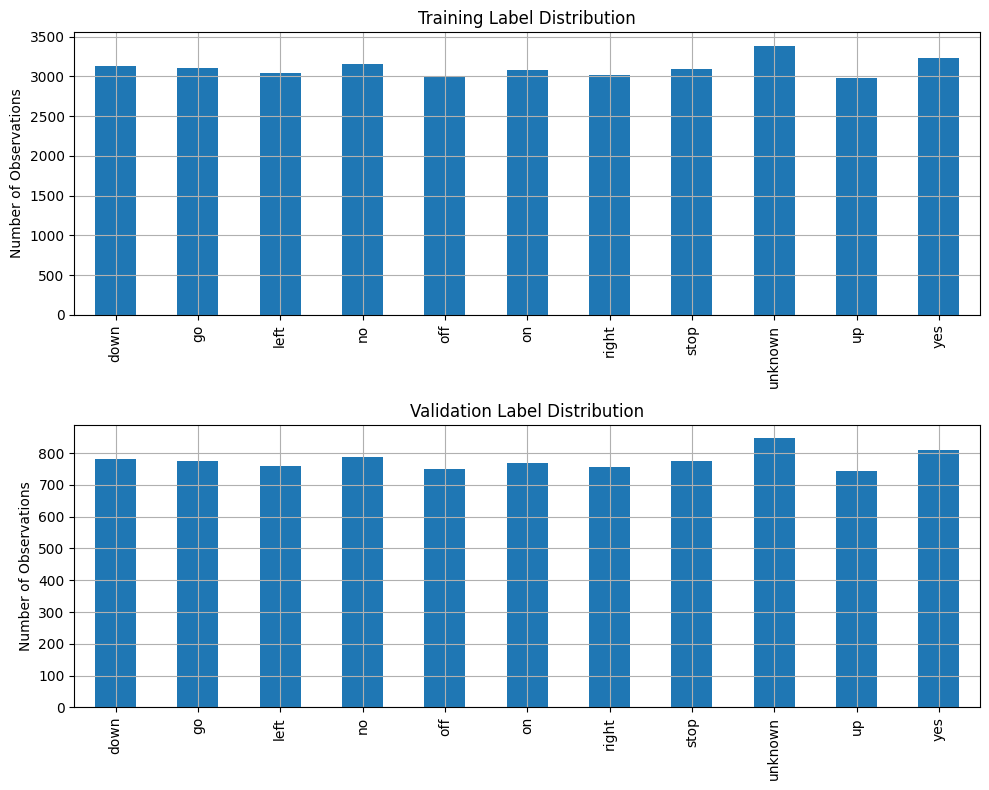

In [9]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
train_df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Training Label Distribution")
plt.ylabel("Number of Observations")
plt.grid(True)

plt.subplot(2, 1, 2)
val_df["label"].value_counts().sort_index().plot(kind="bar")  # <-- Заменили на val_df
plt.title("Validation Label Distribution")
plt.ylabel("Number of Observations")
plt.grid(True)

plt.tight_layout()
plt.show()


**Преобразование аудио в логарифмические спектрограммы Bark-подобные (mel)**

Mel-шкала приближена к слуховому восприятию.

Логарифмирование усиливает тихие звуки (например, согласные).

In [10]:
fs = 16000  # частота дискретизации 
segment_duration = 1.0  # длина сегмента в секундах 
frame_duration = 0.025  # длина фрейма для STFT 
hop_duration = 0.010  # шаг между фреймами 
num_bands = 50  # количество полос Mel-фильтров 

segment_samples = int(fs * segment_duration)
frame_samples = int(fs * frame_duration)
hop_samples = int(fs * hop_duration)

In [11]:
# Параметры аугментаций
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),  # Шум
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.2),  # Изменение скорости
    PitchShift(min_semitones=-2, max_semitones=2, p=0.3),  # Сдвиг тона
    Shift(min_shift=-0.5, max_shift=0.5, p=0.2),  # Сдвиг во времени
    Gain(min_gain_db=-6, max_gain_db=6, p=0.2)  # Изменение громкости
])

это преобразование с аудиоментацией

In [12]:
def process_file(path, augment=False):
    try:
        y, _ = librosa.load(path, sr=fs)
        
        if augment:
            y = augmenter(samples=y, sample_rate=fs)
        
        y = librosa.util.fix_length(data=y, size=segment_samples)
        
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=fs,
            n_fft=512,
            hop_length=160,
            win_length=400,
            window="hann",
            n_mels=64,
            power=1
        )
        return np.log10(mel + 1e-6)[..., np.newaxis]
    
    except Exception as e:
        print(f"Ошибка в файле {path}: {str(e)}")
        return None

In [13]:
def extract_features(file_paths, use_parallel=True):
    if use_parallel:
        with mp.Pool(processes=mp.cpu_count()) as pool:
            return list(tqdm(pool.imap(process_file, file_paths), total=len(file_paths)))
    else:
        return [process_file(f) for f in tqdm(file_paths)]

In [21]:
import zipfile
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [14]:
# Извлечение признаков с аугментацией для train
X_train = [process_file(f, augment=True) for f in tqdm(train_df["file_path"])]
X_val = [process_file(f, augment=False) for f in tqdm(val_df["file_path"])]

# Приводим к формату [Samples, Bands, Time, Channels]
X_train = np.stack([x[..., np.newaxis] for x in X_train if x is not None])
X_val = np.stack([x[..., np.newaxis] for x in X_val if x is not None])

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)

100%|██████████| 8556/8556 [01:06<00:00, 128.20it/s]


X_train.shape: (34222, 64, 101, 1, 1)
X_val.shape: (8556, 64, 101, 1, 1)


In [15]:
X_train = np.squeeze(X_train, axis=-1)  # (51608, 64, 101, 1)
X_val = np.squeeze(X_val, axis=-1)      # (12902, 64, 101, 1)
print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)

X_train.shape: (34222, 64, 101, 1)
X_val.shape: (8556, 64, 101, 1)


**cnn-trad-fpool3**

In [32]:
X_train = extract_features(train_df["file_path"].tolist())
X_val = extract_features(val_df["file_path"].tolist())

# Преобразование в numpy array и добавление размерности канала
X_train_np = np.array([x for x in X_train if x is not None])[..., np.newaxis]
X_val_np = np.array([x for x in X_val if x is not None])[..., np.newaxis]

# Подготовка меток
y_train_cat = train_df["label"].cat.codes.values[:len(X_train_np)]
y_val_cat = val_df["label"].cat.codes.values[:len(X_val_np)]
# После извлечения признаков:
X_train_np = np.array([x for x in X_train if x is not None])
X_val_np = np.array([x for x in X_val if x is not None])

# Проверка формы
print("Shape before reshape:", X_train_np.shape)  # Должно быть (n_samples, n_mels, n_frames)

# # Добавляем размерность канала
# X_train_np = X_train_np[..., np.newaxis]  # Теперь (n_samples, n_mels, n_frames, 1)
# X_val_np = X_val_np[..., np.newaxis]

# print("Shape after reshape:", X_train_np.shape)

100%|██████████| 8556/8556 [00:38<00:00, 221.74it/s]


Shape before reshape: (34222, 64, 101, 1)


In [42]:
def build_cnn_trad_fpool3(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Увеличиваем количество фильтров
        layers.Conv2D(128, kernel_size=(9, 20), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 1)),
        
        # Добавляем dropout для регуляризации
        layers.Dropout(0.25),
        
        layers.Conv2D(128, kernel_size=(4, 10), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        # Глобальный пулинг вместо Flatten
        layers.GlobalAveragePooling2D(),
        
        # Увеличиваем плотный слой
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

2025-05-26 20:53:24.417800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


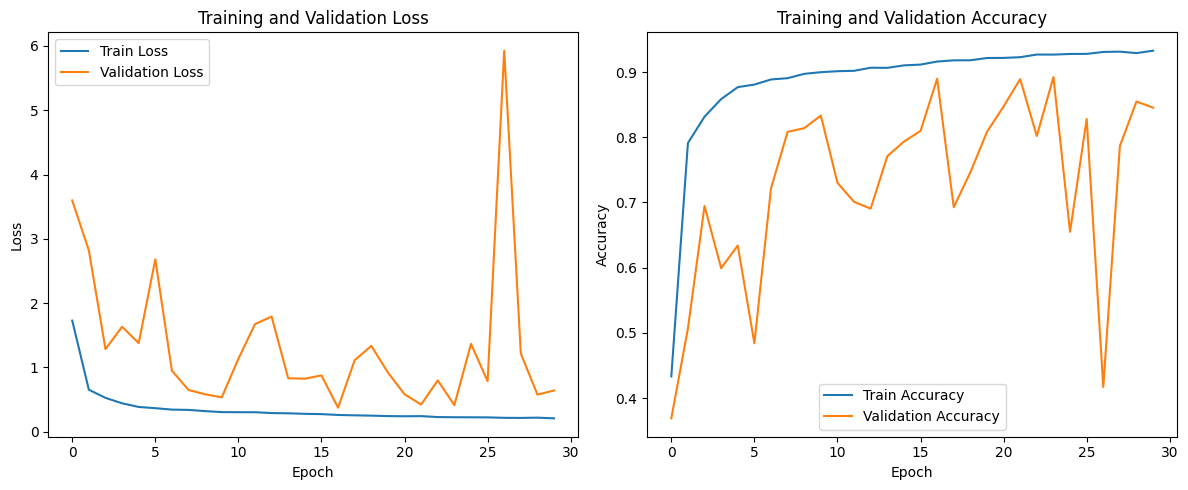


Обучение завершено. Модель сохранена как 'cnn_trad_fpool3.h5'


In [44]:
import tensorflow as tf
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

# 1. Параметры обучения
base_lr = 0.01
num_epochs = 30
warmup_epochs = 3

# 2. Создаем модель
model = build_cnn_trad_fpool3(input_shape=X_train_np.shape[1:], 
                            num_classes=len(np.unique(y_train_cat)))

# 3. Компиляция с обычной кросс-энтропией
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Обучение (без промежуточной визуализации)
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}", end='\r')
    
    # Warmup learning rate
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
        tf.keras.backend.set_value(model.optimizer.lr, lr)
    
    # Одна эпоха обучения
    epoch_history = model.fit(
        X_train_np, y_train_cat,
        validation_data=(X_val_np, y_val_cat),
        batch_size=64,
        epochs=1,
        verbose=0
    )
    
    # Сохраняем метрики
    for key in history.keys():
        history[key].append(epoch_history.history[key][0])

# 5. Финальный график
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Сохранение модели
model.save('cnn_trad_fpool3.h5')
print("\nОбучение завершено. Модель сохранена как 'cnn_trad_fpool3.h5'")

**2 модель - cnn-one-fstride4**

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [51]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, label_to_index):
        self.file_paths = file_paths
        self.labels = labels
        self.label_to_index = label_to_index
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        y, _ = librosa.load(self.file_paths[idx], sr=fs)
        y = librosa.util.fix_length(data=y, size=segment_samples)
        
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=fs,
            n_fft=512,
            hop_length=hop_samples,
            win_length=frame_samples,
            window="hann",
            n_mels=num_bands,
            power=1,
            center=False,
        )
        log_mel = np.log10(mel + 1e-6)
        log_mel = torch.FloatTensor(log_mel).unsqueeze(0)  # [1, bands, time]
        
        label = self.label_to_index[self.labels[idx]]
        return log_mel, label


In [57]:
class CNNOneFstride4(nn.Module):
    def __init__(self, input_time_dim=97, num_bands=64, num_classes=11):
        super(CNNOneFstride4, self).__init__()
        
        # Конволюционный слой
        self.conv = nn.Conv2d(1, 186, kernel_size=(num_bands, 8), stride=(1, 4), padding=(0, 2))
        
        # Расчет размерности после свертки:
        # По частоте: (64 - 64 + 0)/1 + 1 = 1 (полная свертка по частоте)
        # По времени: (97 + 4 - 8)/4 + 1 = 24 (с padding=2)
        self.time_dim_after_conv = 24
        self.flat_features = 186 * 1 * self.time_dim_after_conv  # 186 * 1 * 24 = 4464
        
        # Полносвязные слои
        self.fc1 = nn.Linear(self.flat_features, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Вход: [batch, 1, 64, 97]
        x = self.relu(self.conv(x))  # [batch, 186, 1, 24]
        
        # Выравнивание
        x = x.view(x.size(0), -1)  # [batch, 4464]
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [58]:
test_input, _ = train_dataset[0]
print("Размерность входа:", test_input.shape) 
input_time_dim = test_input.shape[2]  # Временная размерность
num_bands = test_input.shape[1]       # Количество частотных полос

print(f"Требуемые параметры: input_time_dim={input_time_dim}, num_bands={num_bands}")

Размерность входа: torch.Size([1, 64, 97])
Требуемые параметры: input_time_dim=97, num_bands=64


Размерность входа: torch.Size([1, 64, 97])
Размерность выхода модели: torch.Size([1, 11])

Epoch 1/30
Train Loss: 2.2328 | Acc: 0.1823
Val Loss: 1.9590 | Acc: 0.3062
Current LR: 0.000200

Epoch 2/30
Train Loss: 1.8409 | Acc: 0.3254
Val Loss: 1.5873 | Acc: 0.4182
Current LR: 0.000400

Epoch 3/30
Train Loss: 1.5575 | Acc: 0.4308
Val Loss: 1.2886 | Acc: 0.5389
Current LR: 0.000600

Epoch 4/30
Train Loss: 1.3659 | Acc: 0.5029
Val Loss: 1.0695 | Acc: 0.6374
Current LR: 0.000800

Epoch 5/30
Train Loss: 1.2058 | Acc: 0.5691
Val Loss: 0.9437 | Acc: 0.6717
Current LR: 0.001000

Epoch 6/30
Train Loss: 1.0742 | Acc: 0.6168
Val Loss: 0.9043 | Acc: 0.6925
Current LR: 0.001000

Epoch 7/30
Train Loss: 0.9646 | Acc: 0.6597
Val Loss: 0.7616 | Acc: 0.7338
Current LR: 0.001000

Epoch 8/30
Train Loss: 0.9132 | Acc: 0.6789
Val Loss: 0.7540 | Acc: 0.7397
Current LR: 0.001000

Epoch 9/30
Train Loss: 0.8578 | Acc: 0.6986
Val Loss: 0.6962 | Acc: 0.7641
Current LR: 0.001000

Epoch 10/30
Train Loss: 0.8146 | Acc

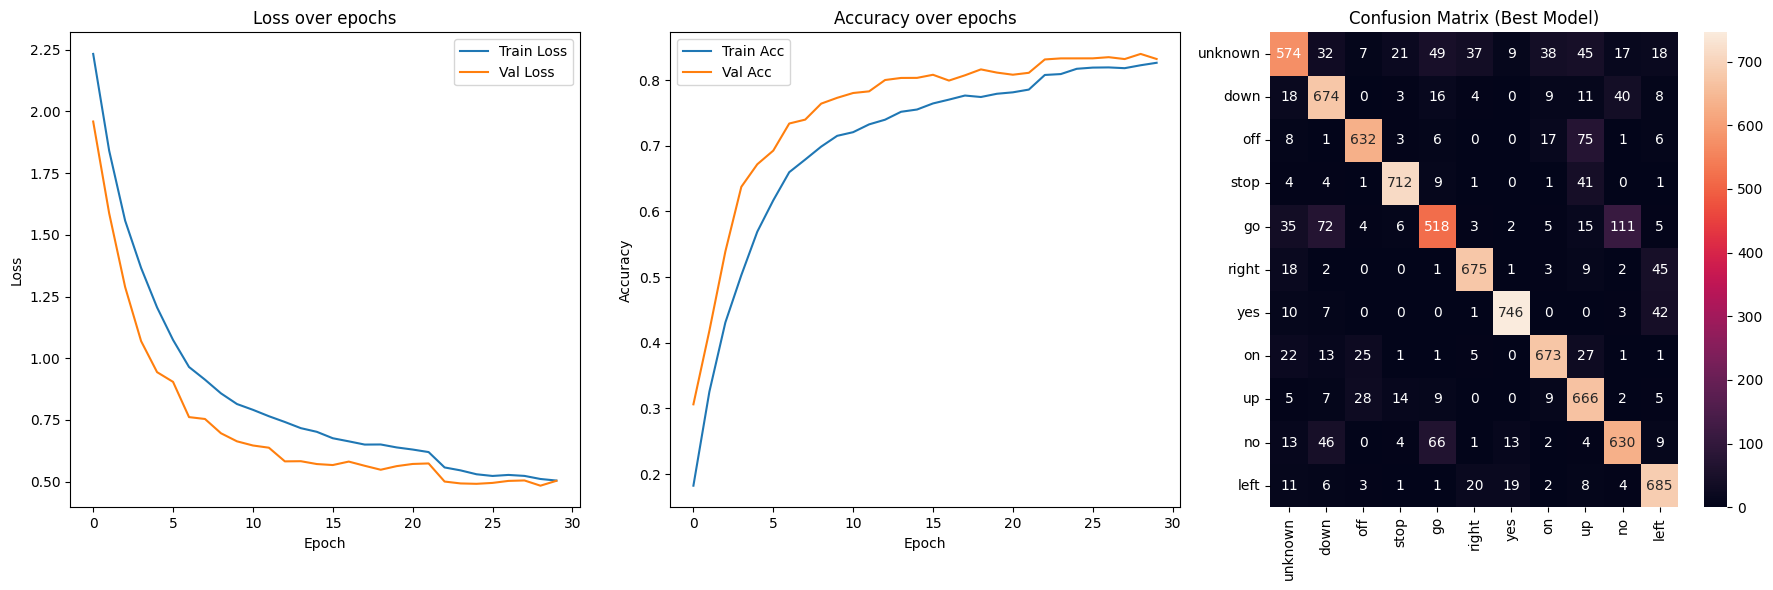


Classification Report for Best Model:
              precision    recall  f1-score   support

     unknown       0.80      0.68      0.73       847
        down       0.78      0.86      0.82       783
         off       0.90      0.84      0.87       749
        stop       0.93      0.92      0.93       774
          go       0.77      0.67      0.71       776
       right       0.90      0.89      0.90       756
         yes       0.94      0.92      0.93       809
          on       0.89      0.88      0.88       769
          up       0.74      0.89      0.81       745
          no       0.78      0.80      0.79       788
        left       0.83      0.90      0.86       760

    accuracy                           0.84      8556
   macro avg       0.84      0.84      0.84      8556
weighted avg       0.84      0.84      0.84      8556



In [ ]:
def train_model(model, train_loader, val_loader, epochs=30):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Режим обучения
        model.train()
        train_loss, train_acc = 0.0, 0.0
        
        # Warmup learning rate
        if epoch < 5:
            lr = 0.001 * (epoch + 1) / 5
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)
        
        # Режим валидации
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Средние значения
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Обновление learning rate
        scheduler.step(val_acc)
        
        # Сохранение лучшей модели
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_cnn_one_fstride4.pth')
            # Сохраняем предсказания для лучшей модели
            best_preds = all_preds
            best_labels = all_labels
        
        # Вывод метрик на каждой эпохе
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Построение итоговых графиков
    plt.figure(figsize=(18, 6))
    
    # График потерь
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # График точности
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Матрица ошибок для лучшей модели
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(best_labels, best_preds)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=label_to_index.keys(), 
                yticklabels=label_to_index.keys())
    plt.title('Confusion Matrix (Best Model)')
    plt.tight_layout()
    
    plt.savefig('training_results.png')
    plt.show()
    
    # Classification report для лучшей модели
    print("\nClassification Report for Best Model:")
    print(classification_report(best_labels, best_preds, target_names=label_to_index.keys()))
    
    return model

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 11

# Создание словаря меток
unique_labels = train_df["label"].unique()
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Подготовка данных
train_dataset = AudioDataset(train_df["file_path"].values, train_df["label"].values, label_to_index)
val_dataset = AudioDataset(val_df["file_path"].values, val_df["label"].values, label_to_index)

# Проверка размерности одного примера
test_input, _ = train_dataset[0]
print(f"Размерность входа: {test_input.shape}")  

# Инициализация модели с правильной временной размерностью
model = CNNOneFstride4(input_time_dim=test_input.shape[2], num_classes=num_classes).to(device)

# Проверка размерностей
test_output = model(test_input.unsqueeze(0).to(device))
print(f"Размерность выхода модели: {test_output.shape}") 

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# Функция для расчета точности
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Функция оценки 
def evaluate(model, loader):
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)
    return val_loss / len(loader), val_acc / len(loader)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Запуск обучения
model = train_model(model, train_loader, val_loader)

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_cnn_one_fstride4.pth'))
final_val_loss, final_val_acc = evaluate(model, val_loader)
print(f"\nFinal Validation Metrics - Accuracy: {final_val_acc:.4f}, Loss: {final_val_loss:.4f}")

# Запуск обучения
model = train_model(model, train_loader, val_loader)

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_cnn_one_fstride4.pth'))
final_val_loss, final_val_acc = evaluate(model, val_loader)
print(f"\nFinal Validation Metrics - Accuracy: {final_val_acc:.4f}, Loss: {final_val_loss:.4f}")